In [1]:
from typing import Dict
from time import perf_counter_ns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cirq
import openfermion as of
import quimb.tensor as qtn
from adaptvqe.pools import FullPauliPool, TiledPauliPool
from adaptvqe.algorithms.adapt_vqe import TensorNetAdapt, LinAlgAdapt
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.tensor_helpers import pauli_sum_to_mpo

## l = 4

In [2]:
max_mpo_bond = 100
system_size = 4
max_mps_bonds = [1, 4, 8]
l = system_size

dmrg_energies: Dict[int, float] = {}
for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l)
    qs = cirq.LineQubit.range(l)
    h_cirq = of.transforms.qubit_operator_to_pauli_sum(h.operator)
    h_mpo = pauli_sum_to_mpo(h_cirq, qs, max_mpo_bond)

    dmrg = qtn.DMRG(h_mpo, chi)
    converged = dmrg.solve()
    if not converged:
        print("DRMG did not converge.")
    ground_energy = dmrg.energy
    print(f"At chi={chi} got energy {ground_energy}.")
    dmrg_energies[chi] = ground_energy

At chi=1 got energy (-2.1708203932499446-4.440892098500626e-16j).
At chi=4 got energy (-6.464101615137765-1.3722833820503584e-15j).
At chi=8 got energy (-6.464101615137766-8.881784197001252e-16j).


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


In [3]:
adapt_energies: Dict[int, float] = {}
adapt_runtimes: Dict[int, float] = {}

for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, system_size)
    start_time = perf_counter_ns()
    pool = FullPauliPool(n=system_size, max_mpo_bond=max_mpo_bond)
    tn_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=True,
        threshold=10**-5,
        max_adapt_iter=30,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=max_mpo_bond,
        max_mps_bond=chi
    )
    tn_adapt.run()
    end_time = perf_counter_ns()
    elapsed_time = end_time - start_time
    print(f"For chi={chi} got energy {tn_adapt.energy} in {elapsed_time:4.5e} ns.")
    adapt_energies[chi] = tn_adapt.energy
    adapt_runtimes[chi] = elapsed_time


tensor-net-adapt prepared with the following settings:
> Pool: full_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 26: -4.000000000000003
Operator 27: 4.000000000000003
Operator 30: -4.000000000000003
Operator 31: 4.000000000000003
Operator 74: 4.000000000000003
Operator 75: -4.000000000000003
Operator 78: 4.000000000000003
Operator 79: -4.000000000000003
Operator 134: 4.000000000000012
Operator 135: -4.000000000000012
Operator 146: -4.000000000000012
Operator 147: 4.000000000000012
Operator 161: -4.000000000000005
Operator 164

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -6.000000
         Iterations: 7
         Function evaluations: 51
         Gradient evaluations: 39

Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 6.742662161940416e-08
Operator 4: -6.742662206349337e-08
Operator 16: 1.4555409599825708e-07
Operator 21: 1.455540962203017e-07
Operator 26: 1.1184078685388954e-07
Operator 27: -2.0000000000000004
Operator 30: 2.0000000000000004
Operator 31: -1.1184078707593414e-07
Operator 38: 3.3713307034943796e-08
Operator 39: 2.0000000000000036
Operator 45: -2.000000000000004
Operator 54: -2.000000000000003
Operator 55: -3.371330625778768e-08
Operator 57: 2.0000000000000027
Operator 64: -1.4555409588723478e-07
Operator 69: -1.4555409610927939e-07
Operator 74: -1.1184078663184494e-07
Operator 75: 2.000000000000001
Operator 78: -2

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -6.327276
         Iterations: 4
         Function evaluations: 57
         Gradient evaluations: 45

Current energy: -6.3272761548197165
(change of -0.20417052920207368)
Current ansatz: [241, 74, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 1.818746864223897e-08
Operator 4: -1.8187468392438788e-08
Operator 16: -3.883807953020124e-08
Operator 21: -3.8838078808556276e-08
Operator 26: -4.7184784607301467e-08
Operator 27: 6.5717189216464365e-06
Operator 30: -0.7090369775230967
Operator 31: 4.3687630589539506e-08
Operator 38: 1.8093580592126735e-08
Operator 39: 2.089489963107906
Operator 45: -2.08949292673488
Operator 54: 0.7090282438180852
Operator 57: 5.125613064015391e-06
Operator 64: 3.8838078753045124e-08
Operator 69: 3.8838079516323454e-08
Operator 74: 4.368763089485084e-08
Operator 75: -0.7090369775230969
Operator 78: 6.57171892143982e-06

In [4]:
records = []
for chi in max_mps_bonds:
    records.append((chi, dmrg_energies[chi], adapt_energies[chi], adapt_runtimes[chi]))
df = pd.DataFrame.from_records(records, columns=["chi", "dmrg_energy", "adapt_energy", "adapt_runtime"])
df.to_csv("../data/xxz_energy_vs_bond.csv")

In [5]:
df["error"] = np.abs(df['dmrg_energy'] - df["adapt_energy"])

In [6]:
print(df.head())

   chi         dmrg_energy  adapt_energy  adapt_runtime         error
0    1 -2.170820-0.000000j     -3.000000     8145285750  8.291796e-01
1    4 -6.464102-0.000000j     -6.464102     8516975625  2.419398e-12
2    8 -6.464102-0.000000j     -6.464102     8821096042  3.996448e-11


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$\\chi$')

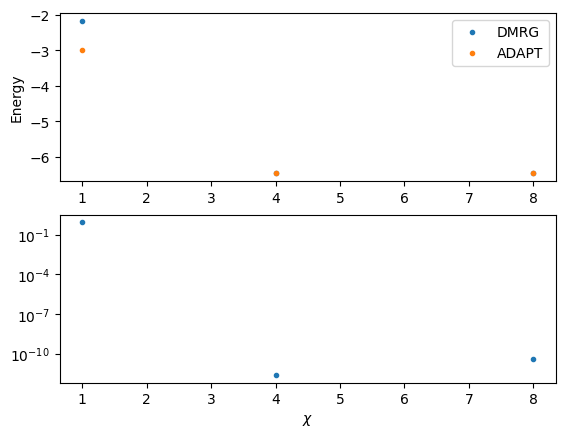

In [7]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(df["chi"], df["dmrg_energy"], '.', label="DMRG")
ax[0].plot(df["chi"], df["adapt_energy"], '.', label="ADAPT")
ax[0].legend()
ax[0].set_ylabel("Energy")
ax[1].plot(df["chi"], df["error"], '.')
ax[1].set_yscale("log")
ax[1].set_xlabel(r"$\chi$")

## l = 6

In [8]:
max_mpo_bond = 100
system_size = 6
max_mps_bonds = [1, 4, 8]
l = system_size

dmrg_energies: Dict[int, float] = {}
for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l)
    qs = cirq.LineQubit.range(l)
    h_cirq = of.transforms.qubit_operator_to_pauli_sum(h.operator)
    h_mpo = pauli_sum_to_mpo(h_cirq, qs, max_mpo_bond)

    dmrg = qtn.DMRG(h_mpo, chi)
    converged = dmrg.solve()
    if not converged:
        print("DRMG did not converge.")
    ground_energy = dmrg.energy
    print(f"At chi={chi} got energy {ground_energy}.")
    dmrg_energies[chi] = ground_energy

At chi=1 got energy (-3.618033492546621-2.9976021664879227e-15j).
At chi=4 got energy (-9.970167158141367+3.3306690738754696e-15j).
At chi=8 got energy (-9.97430853555169+2.220446049250313e-15j).


In [9]:
adapt_energies: Dict[int, float] = {}
adapt_runtimes: Dict[int, float] = {}

for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, system_size)
    start_time = perf_counter_ns()
    pool = FullPauliPool(n=system_size, max_mpo_bond=max_mpo_bond)
    tn_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=True,
        threshold=10**-5,
        max_adapt_iter=30,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=max_mpo_bond,
        max_mps_bond=chi
    )
    tn_adapt.run()
    end_time = perf_counter_ns()
    elapsed_time = end_time - start_time
    print(f"For chi={chi} got energy {tn_adapt.energy} in {elapsed_time:4.5e} ns.")
    adapt_energies[chi] = tn_adapt.energy
    adapt_runtimes[chi] = elapsed_time


tensor-net-adapt prepared with the following settings:
> Pool: full_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -4.999999999999999

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 426: 3.9999999999999964
Operator 427: -3.9999999999999964
Operator 430: 3.9999999999999964
Operator 431: -3.9999999999999964
Operator 442: -3.9999999999999964
Operator 443: 3.9999999999999964
Operator 446: -3.9999999999999964
Operator 447: 3.9999999999999964
Operator 490: 3.9999999999999964
Operator 491: -3.9999999999999964
Operator 494: 3.9999999999999964
Operator 495: -3.9999999999999964
Operator 506: -3.999999999

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.464102
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14

Current energy: -9.46410161422203
(change of -0.13682545940232238)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954]

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -8.467423934233054e-08
Operator 4: 8.469391105103696e-08
Operator 26: 2.665432108361898e-08
Operator 27: 2.851773172110071e-07
Operator 30: -4.7253141637232694e-05
Operator 31: -2.6689486620767866e-08
Operator 38: -1.5430997452048345e-08
Operator 39: 7.393150245976943e-06
Operator 41: -1.1377282060909266e-08
Operator 45: 3.6764381556240734e-05
Operator 54: 0.0001678950683045261
Operator 55: 1.556160805771256e-08
Operator 57: -0.000165084635787309
Operator 61: 1.128333021460648e-08
Operator 74: -2.668948673179017e-08
Operator 75: -4.725314163707875e-05
Operator 78: 2.8517731759893035e-07
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.592826
         Iterations: 6
         Function evaluations: 46
         Gradient evaluations: 34

Current energy: -9.592825926710528
(change of -0.12872431248849914)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456]

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 4.060538308618342e-06
Operator 4: -3.997643591894563e-06
Operator 16: -5.11912432787226e-07
Operator 21: -4.482851390947423e-07
Operator 26: -1.8312774305757895e-06
Operator 27: -0.02884396432742781
Operator 30: 0.027499585948237322
Operator 31: 1.726262939977588e-06
Operator 38: 9.516288343208897e-07
Operator 39: -0.001231812560934468
Operator 41: 4.5631590038074793e-07
Operator 45: 0.013695212600633395
Operator 54: 0.006077842351298814
Operator 55: -5.613116064733144e-07
Operator 57: -0.017283769971819792
Operator 61: -7.34955679556823e-07
Operator 64: 3.179574375664074e-07
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.812023
         Iterations: 6
         Function evaluations: 61
         Gradient evaluations: 49

Current energy: -9.81202285998041
(change of -0.2191969332698811)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605]

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.733998041293262e-06
Operator 4: -2.964614428613288e-06
Operator 16: 2.3276112028902674e-06
Operator 21: 2.0917787977303703e-06
Operator 26: 1.6150763275657454e-06
Operator 27: -0.05163120072866466
Operator 30: 0.05216110085453416
Operator 31: -1.1883735857587396e-06
Operator 38: -3.305697224842419e-07
Operator 39: -0.006981528212156675
Operator 41: 8.312562438383964e-07
Operator 45: 0.028931117764326532
Operator 54: 0.004732123444185169
Operator 55: -1.1887769895135847e-06
Operator 57: -0.027489293870482906
Operator 61: 2.7071363062347586e-07
Operator 64: -2.63578482950777e-06

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.954770
         Iterations: 15
         Function evaluations: 61
         Gradient evaluations: 49

Current energy: -9.954770429713847
(change of -0.14274756973343727)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599]

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -0.0010108702253235318
Operator 4: 0.0009717259266736826
Operator 16: 0.00033647727456139853
Operator 21: 0.000299068088502877
Operator 26: 0.00064691729614682
Operator 27: -0.023137981976719263
Operator 30: 0.034382063960292496
Operator 31: -0.0005773743456349733
Operator 38: -0.00029029530517687014
Operator 39: -0.028686018876673363
Operator 41: -6.52861762248495e-05
Operator 45: 0.037790979032933415
Operator 54: -0.011193515151006542
Operator 55: 3.098927970330808e-05
Operator 57: -0.009154678478915703
Operator 61: 0.0002669030748427548
Operator 64: -0.0003328016371

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958635
         Iterations: 2
         Function evaluations: 58
         Gradient evaluations: 46

Current energy: -9.958635268951678
(change of -0.003864839237831319)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685]

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.6349669987713042e-05
Operator 4: -2.7777808542905902e-05
Operator 16: 1.304164067728042e-05
Operator 21: 1.1598257746436857e-05
Operator 26: 5.051316365689562e-06
Operator 27: -0.003313884290387731
Operator 30: -0.0031911499754030794
Operator 31: -2.6773801338197956e-06
Operator 38: 5.575618836073382e-07
Operator 39: 0.0019888742511625116
Operator 41: 6.16524150220954e-06
Operator 45: -0.003190865000757587
Operator 54: 0.008237346796014424
Operator 55: -8.839951734118667e-06
Operator 57: 0.0016708472582774776
Operator 61: -1.1671471500385167e-07
Operator 64: -1.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958635
         Iterations: 0
         Function evaluations: 35
         Gradient evaluations: 24

Current energy: -9.95863526895168
(change of -1.7763568394002505e-15)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745]

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.6349669985326063e-05
Operator 4: -2.7777808538798077e-05
Operator 16: 1.304164067558733e-05
Operator 21: 1.1598257746409102e-05
Operator 26: 5.051316364412806e-06
Operator 27: -0.003313884290387199
Operator 30: -0.003191149975403425
Operator 31: -2.6773801339030623e-06
Operator 38: 5.575618835171325e-07
Operator 39: 0.001988874251161313
Operator 41: 6.165241501682184e-06
Operator 45: -0.0031908650007560404
Operator 54: 0.008237346796016105
Operator 55: -8.839951732918239e-06
Operator 57: 0.0016708472582764925
Operator 61: -1.1671471578100778e-07
Operator 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 306: 0.1189324115945265
Operator 307: -1.0223759986782016e-06
Operator 312: -0.056516247630640136
Operator 316: -1.662456250987876e-06
Operator 321: 8.631720822827038e-06
Operator 324: -9.606794319050316e-06
Operator 336: -1.1956068227680916e-06
Operator 341: -2.19723853425724e-06
Operator 346: -7.341826843955401e-06
Operator 347: 0.388097055418526
Operator 350: -0.41052922033481987
Operator 351: 8.209654389780552e-06
Operator 358: 3.617206361352515e-06
Operator 359: -0.21576490015526956
Operator 361: 3.969553133836845e-07
Operator 365: 0.15753667789571557
Operator 374: 0.26521836578594726
Operator 375: -6.048093542682098e-06
Operator 377: -0.1901110334829435
Operator 381: 9.843729853187266e-07
Operator 386: -4.3448206904833295e-06
Operator 387: 0.19310541757271107
Operator 392: 1.9428561587302856e-06
Operator 396: -0.028347447197283368
Operator 406: -4.761149970536685e-06
Operator 407: 0.2087033209537866
Operator 409: 2.5641577154986855e-06
Operator 413: -0.045840834502650536

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958646
         Iterations: 1
         Function evaluations: 72
         Gradient evaluations: 58

Current energy: -9.95864638892445
(change of -1.1119972739948025e-05)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060]

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.422642890032023e-05
Operator 4: -2.5701348100426458e-05
Operator 16: 1.3375236763923937e-05
Operator 21: 1.1882700392984447e-05
Operator 26: 6.2794386759268406e-06
Operator 27: -0.03918370128332371
Operator 30: 0.037224182281767215
Operator 31: -3.779896746269884e-06
Operator 38: -9.641970055707105e-08
Operator 39: 0.0004044431686936367
Operator 41: 5.982899426548727e-06
Operator 45: 0.010390763665389581
Operator 54: -0.004528861456000077
Operator 55: -8.631442904305509e-06
Operator 57: -0.003016865564020051
Operator 61: 4.013905545718899e-07


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958646
         Iterations: 0
         Function evaluations: 40
         Gradient evaluations: 28

Current energy: -9.958646388924434
(change of 1.5987211554602254e-14)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241]

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.422642890076432e-05
Operator 4: -2.570134809953828e-05
Operator 16: 1.33752367582618e-05
Operator 21: 1.1882700388543554e-05
Operator 26: 6.2794386711528816e-06
Operator 27: -0.039183701283325434
Operator 30: 0.03722418228176874
Operator 31: -3.779896740052635e-06
Operator 38: -9.641969783702464e-08
Operator 39: 0.0004044431686931128
Operator 41: 5.982899423218058e-06
Operator 45: 0.010390763665391692
Operator 54: -0.004528861455999673
Operator 55: -8.631442907636178e-06
Operator 57: -0.0030168655640220705
Operator 61: 4.013905563482467e

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 957: 0.2056886415481751
Operator 961: -8.994256355254748e-06
Operator 964: 9.585182466076425e-06
Operator 976: -4.250863948868089e-06
Operator 981: -3.7847644492883248e-06
Operator 986: -2.1377682006551435e-07
Operator 987: -0.19731939437750612
Operator 990: 0.26244167292495924
Operator 991: -1.2174334399761566e-06
Operator 998: -1.1281797985401854e-06
Operator 999: 0.16903624819078023
Operator 1001: -2.373119438764393e-06
Operator 1005: -0.21929577888197396
Operator 1014: -0.39325083904971364
Operator 1015: 5.428499290832667e-06
Operator 1017: 0.37318946165025385
Operator 1021: 3.9946894642151065e-07
Operator 1024: 2.0642412700833113e-06
Operator 1029: 1.1209345383567104e-06
Operator 1034: 7.608300039124716e-06
Operator 1035: -0.3910431408226334
Operator 1038: 0.3780180798769226
Operator 1039: -6.687305831837298e-06
Operator 1041: 8.808491646472572e-06
Operator 1044: -7.894537710217975e-06
Operator 1058: -5.8046995911748e-06
Operator 1059: 0.2594805784899828
Operator 1064: 1.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 361: 5.051023786450948e-07
Operator 365: 0.19200741722007028
Operator 374: 0.25948057848998285
Operator 375: -5.804699591922466e-06
Operator 377: -0.2009119364610608
Operator 381: 1.0983417158480502e-06
Operator 386: -4.306602193042755e-06
Operator 387: 0.19945807761574144
Operator 392: 2.0286933233673067e-06
Operator 396: -0.02641779044595222
Operator 406: -4.597299768108621e-06
Operator 407: 0.23634198033573012
Operator 409: 2.380550390001547e-06
Operator 413: -0.07374381820513479
Operator 416: -7.103564085886999e-06
Operator 421: -7.407546136367106e-06
Operator 426: -1.0653367119993484e-05
Operator 427: 0.388917805103872
Operator 430: -0.29892625090415664
Operator 431: 9.231598325659153e-06
Operator 432: -0.17852962767516392
Operator 437: -0.16663640149556042
Operator 442: -0.09856174153121713
Operator 443: -1.2891306399678316e-06
Operator 446: 2.771249907830098e-06
Operator 447: 0.004186125214257786
Operator 450: -0.24424870190270984
Operator 451: 1.825143834026724e-06
Ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958846
         Iterations: 1
         Function evaluations: 54
         Gradient evaluations: 42

Current energy: -9.958845588535109
(change of -0.00019919961065717473)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556]

*** ADAPT-VQE Iteration 18 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.0501260505692565e-05
Operator 4: -2.2016333291505208e-05
Operator 16: 1.376808644625721e-05
Operator 21: 1.2273455297057145e-05
Operator 26: 8.178145685096977e-06
Operator 27: -0.09200015964943199
Operator 30: 0.09532369434707727
Operator 31: -5.50504143414024e-06
Operator 38: -1.3869587486316226e-06
Operator 39: -0.013221617557109135
Operator 41: 5.9094239474519195e-06
Operator 45: 0.04278608072256862
Operator 54: -0.012643113113742261
Operator 55: -8.174653321127781e-06
Operator 57: -0.02069604417634718
Operator 61: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958846
         Iterations: 0
         Function evaluations: 33
         Gradient evaluations: 22

Current energy: -9.958845588535112
(change of -3.552713678800501e-15)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556, 3668]

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.0501260505012553e-05
Operator 4: -2.2016333292518286e-05
Operator 16: 1.3768086447346617e-05
Operator 21: 1.2273455296668567e-05
Operator 26: 8.178145684059612e-06
Operator 27: -0.09200015964943177
Operator 30: 0.09532369434707684
Operator 31: -5.5050414339979925e-06
Operator 38: -1.3869587484685586e-06
Operator 39: -0.013221617557108456
Operator 41: 5.909423945710257e-06
Operator 45: 0.04278608072256808
Operator 54: -0.01264311311374187
Operator 55: -8.174653321507686e-06
Operator 57: -0.020696044176346844
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958846
         Iterations: 0
         Function evaluations: 40
         Gradient evaluations: 29

Current energy: -9.958845588535114
(change of -1.7763568394002505e-15)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556, 3668, 427]

*** ADAPT-VQE Iteration 20 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.050126051011958e-05
Operator 4: -2.201633329468322e-05
Operator 16: 1.3768086447152328e-05
Operator 21: 1.227345529897228e-05
Operator 26: 8.178145682935511e-06
Operator 27: -0.09200015964943331
Operator 30: 0.0953236943470793
Operator 31: -5.505041434150648e-06
Operator 38: -1.386958748905709e-06
Operator 39: -0.013221617557109523
Operator 41: 5.909423948402548e-06
Operator 45: 0.04278608072257019
Operator 54: -0.012643113113742752
Operator 55: -8.174653323478331e-06
Operator 57: -0.02069604417634685
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958846
         Iterations: 0
         Function evaluations: 37
         Gradient evaluations: 27

Current energy: -9.958845588535123
(change of -8.881784197001252e-15)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556, 3668, 427, 2817]

*** ADAPT-VQE Iteration 21 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.0501260512340025e-05
Operator 4: -2.2016333298680024e-05
Operator 16: 1.3768086447374372e-05
Operator 21: 1.2273455295197522e-05
Operator 26: 8.17814567999342e-06
Operator 27: -0.09200015964943364
Operator 30: 0.0953236943470791
Operator 31: -5.505041431375091e-06
Operator 38: -1.386958748184064e-06
Operator 39: -0.01322161755710971
Operator 41: 5.90942394707028e-06
Operator 45: 0.042786080722569675
Operator 54: -0.01264311311374311
Operator 55: -8.174653323478331e-06
Operator 57: -0.020696044176346517


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 701: 4.254123784314806e-06
Operator 705: -0.022393336581815262
Operator 708: 0.12076935785257054
Operator 720: -0.07387413423907356
Operator 725: 0.022744659137755335
Operator 730: -0.027762371393129013
Operator 731: 2.169831983281909e-06
Operator 734: -1.4867748975877526e-06
Operator 735: -0.027014121204406143
Operator 742: -0.006179684837584328
Operator 743: -7.688217695123048e-07
Operator 745: 0.06243866199368855
Operator 749: 4.0209496636901126e-07
Operator 758: -8.40772778872359e-07
Operator 759: 0.23484722751806592
Operator 761: 6.310507624958384e-08
Operator 765: -0.23280225455131456
Operator 774: 0.28651523759875863
Operator 775: -5.397354586831986e-06
Operator 777: -0.2722459732102492
Operator 781: 3.0857453045905064e-06
Operator 786: -0.045800719876503845
Operator 787: 4.489976774459375e-06
Operator 792: -0.07282448806172825
Operator 796: -2.996443965321005e-06
Operator 801: -0.0037383116416386665
Operator 804: 0.1024521403059606
Operator 817: 3.3926947334492197e-07


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.961190
         Iterations: 3
         Function evaluations: 46
         Gradient evaluations: 34

Current energy: -9.961190078873809
(change of -0.0008740765842993881)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556, 3668, 427, 2817, 3668, 2817, 3321]

*** ADAPT-VQE Iteration 24 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 9.72799654191947e-06
Operator 4: -1.079919172253252e-05
Operator 16: 9.453820094984522e-06
Operator 21: 8.366021901490273e-06
Operator 26: 6.893648494016302e-06
Operator 27: 0.010175910181398268
Operator 30: 0.011600094312848454
Operator 31: -4.996300068949022e-06
Operator 38: -2.203202676562266e-06
Operator 39: -0.06860315152340213
Operator 41: 3.7313093278479315e-06
Operator 45: 0.07070723884713664
Operator 54: 0.00818803227980594
Operator 55: -4.974771702047354e-06
Operator 57: -0.033

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.961242
         Iterations: 1
         Function evaluations: 53
         Gradient evaluations: 42

Current energy: -9.961242399678131
(change of -5.2320804321936976e-05)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556, 3668, 427, 2817, 3668, 2817, 3321, 2040]

*** ADAPT-VQE Iteration 25 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 9.005030029540784e-06
Operator 4: -1.0076835931738248e-05
Operator 16: 9.098624385528442e-06
Operator 21: 7.99276336460597e-06
Operator 26: 6.971187749657548e-06
Operator 27: 0.016928363962587085
Operator 30: 0.0011251773030565182
Operator 31: -5.088136743977567e-06
Operator 38: -2.4834315725946743e-06
Operator 39: -0.061684250528200174
Operator 41: 3.5971901788389715e-06
Operator 45: 0.06014973698162039
Operator 54: 0.01864340816400882
Operator 55: -4.767207799467876e-06
Operator

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.961242
         Iterations: 0
         Function evaluations: 40
         Gradient evaluations: 29

Current energy: -9.961242399678133
(change of -1.7763568394002505e-15)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556, 3668, 427, 2817, 3668, 2817, 3321, 2040, 3416]

*** ADAPT-VQE Iteration 26 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 9.005030030984074e-06
Operator 4: -1.0076835931016603e-05
Operator 16: 9.09862438636111e-06
Operator 21: 7.992763364050859e-06
Operator 26: 6.971187748616714e-06
Operator 27: 0.016928363962587477
Operator 30: 0.001125177303057528
Operator 31: -5.0881367412713985e-06
Operator 38: -2.483431571498329e-06
Operator 39: -0.061684250528199744
Operator 41: 3.597190176396481e-06
Operator 45: 0.06014973698162006
Operator 54: 0.0186434081640097
Operator 55: -4.767207801625872e-06
Opera

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.961242
         Iterations: 0
         Function evaluations: 33
         Gradient evaluations: 22

Current energy: -9.961242399678147
(change of -1.4210854715202004e-14)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556, 3668, 427, 2817, 3668, 2817, 3321, 2040, 3416, 3416]

*** ADAPT-VQE Iteration 27 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 9.005030028319538e-06
Operator 4: -1.007683592746389e-05
Operator 16: 9.098624389025645e-06
Operator 21: 7.992763368491751e-06
Operator 26: 6.971187752169428e-06
Operator 27: 0.016928363962588663
Operator 30: 0.0011251773030560351
Operator 31: -5.088136745157179e-06
Operator 38: -2.4834315727195744e-06
Operator 39: -0.06168425052820089
Operator 41: 3.597190179061016e-06
Operator 45: 0.060149736981621876
Operator 54: 0.018643408164010333
Operator 55: -4.767207798961337e

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 804: 0.1565773695172294
Operator 817: -7.808011289744954e-07
Operator 820: 5.933077851238977e-07
Operator 834: -0.044869059702423664
Operator 835: -4.013825949810042e-06
Operator 840: 0.06618315775241071
Operator 844: 2.691498469313547e-06
Operator 854: 0.09256876396705117
Operator 855: -1.3952395020444541e-06
Operator 857: -0.13281456985811294
Operator 861: -1.7645723857651063e-06
Operator 864: -0.05495756886805885
Operator 869: 0.000906942643170097
Operator 874: -0.03601461981167221
Operator 875: -3.3673551399302643e-06
Operator 878: 1.936297629404754e-06
Operator 879: 0.043489261396246495
Operator 880: 3.12084661265033e-06
Operator 885: 4.541816371134155e-06
Operator 890: 3.407005553228426e-06
Operator 891: -0.05278842228113817
Operator 894: 0.04869015854817612
Operator 895: -1.7811894074681867e-06
Operator 897: 0.04304261116504027
Operator 900: -0.14009000239142347
Operator 912: 0.08696366961247493
Operator 917: -0.006633782469582893
Operator 922: -0.006997774630278117
Ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.961242
         Iterations: 0
         Function evaluations: 34
         Gradient evaluations: 24

Current energy: -9.961242399678172
(change of -1.4210854715202004e-14)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556, 3668, 427, 2817, 3668, 2817, 3321, 2040, 3416, 3416, 2061, 2061]

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 9.005030029540784e-06
Operator 4: -1.007683593179376e-05
Operator 16: 9.098624393244492e-06
Operator 21: 7.992763373321221e-06
Operator 26: 6.971187756929509e-06
Operator 27: 0.016928363962588396
Operator 30: 0.0011251773030576781
Operator 31: -5.088136749570316e-06
Operator 38: -2.483431573857553e-06
Operator 39: -0.06168425052820077
Operator 41: 3.5971901776732373e-06
Operator 45: 0.060149736981619926
Operator 54: 0.018643408164008255
Operator 55: -4.7672

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 38: -2.483431573274686e-06
Operator 39: -0.06168425052820145
Operator 41: 3.5971901781728377e-06
Operator 45: 0.06014973698162149
Operator 54: 0.018643408164008446
Operator 55: -4.767207800848716e-06
Operator 57: -0.03702148335224548
Operator 61: 1.8234490215540688e-06
Operator 64: -1.0714540036982356e-05
Operator 69: -1.085400177913698e-05
Operator 74: -6.9930930957085025e-06
Operator 75: -0.01061903625152788
Operator 78: 0.006805365504886585
Operator 79: 9.076772134353206e-06
Operator 81: 1.0620763728930172e-05
Operator 84: -1.0421896363688177e-05
Operator 98: -3.7997206164819275e-06
Operator 99: -0.021129870421932262
Operator 104: 1.6748483888662236e-07
Operator 108: 0.05179896066907358
Operator 114: 0.03312422824459291
Operator 115: -3.6638278848588612e-06
Operator 120: -0.06794643853379509
Operator 124: 5.190778138430829e-06
Operator 134: 1.0644448099617065e-06
Operator 135: 0.07463849549237572
Operator 137: -5.4066709813671565e-06
Operator 141: -0.04464265625732325
Opera

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.962383
         Iterations: 1
         Function evaluations: 56
         Gradient evaluations: 44

Current energy: -9.962383165996611
(change of -0.001140766318442843)
Current ansatz: [4084, 3919, 1194, 4038, 4068, 3954, 3456, 3605, 1599, 685, 3745, 3060, 3060, 3241, 2556, 3241, 2556, 3668, 427, 2817, 3668, 2817, 3321, 2040, 3416, 3416, 2061, 2061, 3416, 679]
Performing final convergence check...
Total gradient norm: 2.797157124728803

The maximum number of iterations (30) was hit before the convergence criterion was satisfied.
(current gradient norm is 2.8791456091142473 > 1e-05)
For chi=4 got energy -9.962383165996611 in 2.52608e+11 ns.

tensor-net-adapt prepared with the following settings:
> Pool: full_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -8.273427
         Iterations: 11
         Function evaluations: 109
         Gradient evaluations: 96

Current energy: -8.273426869127523
(change of -0.7715290552639855)
Current ansatz: [4051, 3370, 4084, 1258]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 16: 2.0387881605776417
Operator 21: 2.0112921197434583
Operator 26: 2.6472765887357763
Operator 27: -1.6886136839303916
Operator 30: 1.6658402581746934
Operator 31: -2.6115741913063966
Operator 38: -0.5211100280177104
Operator 39: 0.816955583420226
Operator 45: -0.6291746688963746
Operator 54: -0.4417728528318374
Operator 55: 0.6925769594136182
Operator 61: -0.5333850309217838
Operator 64: -2.0387881605776412
Operator 69: -2.011292119743458
Operator 74: -2.6472765887357763
Operator 75: 1.6886136839303916
Operator 78: -1.665840258174694
Operator 79: 2.611574191306397
Operator 98: 0.8169555834202249
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.464102
         Iterations: 9
         Function evaluations: 45
         Gradient evaluations: 33

Current energy: -9.464101614533227
(change of -0.13682545971370885)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020]

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -3.223704001520389e-07
Operator 4: 3.6354174023922603e-07
Operator 16: -1.9286827024345143e-07
Operator 21: -1.516969301285087e-07
Operator 26: -1.0767063995942294e-07
Operator 27: 4.819969980923172e-05
Operator 30: 3.1798631052316154e-06
Operator 31: 3.636465406575695e-08
Operator 38: 4.558097374540715e-08
Operator 39: -0.00014345292965718166
Operator 41: -8.961178349364829e-08
Operator 45: 0.00012693823502153023
Operator 54: -4.829915025515827e-05
Operator 55: 2.2054083972933292e-07
Operator 57: 1.3434281985790978e-05
Operator 61: -1.0521070803459764e-07
Operator 64: 1.51696929129

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.592854
         Iterations: 12
         Function evaluations: 53
         Gradient evaluations: 43

Current energy: -9.592854285200778
(change of -0.12875267066755036)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837]

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -4.7529104119092835e-07
Operator 4: 5.363751809928097e-07
Operator 16: 3.4917601698936096e-07
Operator 21: 4.102601549593743e-07
Operator 26: 5.090068028179573e-07
Operator 27: 7.033062061398636e-08
Operator 30: -1.952438329720381e-07
Operator 31: -6.155747956926305e-07
Operator 38: -4.931897495952242e-08
Operator 39: -5.833576196735828e-07
Operator 41: -4.7573806172263033e-08
Operator 45: 9.013198548868714e-07
Operator 54: 1.0458304574089522e-06
Operator 55: 4.4387133585344074e-07
Operator 57: -1.2380060255171443e-06
Operator 61: -2.396653783764968e-07
Operator 64: -4.102601

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.812121
         Iterations: 14
         Function evaluations: 55
         Gradient evaluations: 41

Current energy: -9.812121034535583
(change of -0.21926674933480506)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370]

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -5.231144830850076e-08
Operator 4: 5.9153939253875354e-08
Operator 16: 1.2511171518063413e-07
Operator 21: 1.3210983289269063e-07
Operator 26: 1.4790091113197484e-07
Operator 27: -2.9294610079668917e-06
Operator 30: 3.3991853536304734e-06
Operator 31: -1.6058452691203318e-07
Operator 38: -2.178835739651344e-08
Operator 39: 1.67552644752755e-08
Operator 45: 6.293454801820713e-07
Operator 54: -1.7054115760219605e-06
Operator 55: 6.734866951846677e-08
Operator 57: 5.757641561936492e-07
Operator 61: -3.915238508400698e-08
Operator 64: -1.3195420679214254e-07
Operator 69: -

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.954831
         Iterations: 14
         Function evaluations: 41
         Gradient evaluations: 29

Current energy: -9.954831343216053
(change of -0.14271030868047063)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221]

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 5.177340727802182e-07
Operator 4: -5.868914276785375e-07
Operator 16: 1.365772794970077e-06
Operator 21: 1.2966154656623985e-06
Operator 26: 1.2761245091613693e-06
Operator 27: -1.547478277848183e-05
Operator 30: 1.2783695019564126e-05
Operator 31: -1.1610513233062392e-06
Operator 38: -2.689182274223656e-07
Operator 39: 3.248054325187702e-06
Operator 41: 2.89410414577862e-07
Operator 45: 4.243820389348451e-06
Operator 54: 6.296742814160813e-06
Operator 55: -1.3922460929960412e-07
Operator 57: -1.1097529760947397e-05
Operator 64: -1.511091308359358e-06
Operator 69

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.959455
         Iterations: 16
         Function evaluations: 29
         Gradient evaluations: 29

Current energy: -9.959454845286514
(change of -0.004623502070460361)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078]

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 8.520534500178201e-08
Operator 4: -9.617010299223239e-08
Operator 16: 6.603282454165083e-08
Operator 21: 5.5148416944206247e-08
Operator 26: 4.2894974239260364e-08
Operator 27: -9.583238708098435e-07
Operator 30: 0.010393990204633722
Operator 31: -2.393721065807597e-08
Operator 38: -1.262818793978937e-08
Operator 39: -0.015170751651995492
Operator 41: 2.5178650275847758e-08
Operator 45: 2.6010071201890635e-07
Operator 54: 3.8049865225994216e-07
Operator 55: -5.424876559079195e-08
Operator 57: -6.771179863589089e-07
Operator 61: 2.229266904407723e-08
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.965154
         Iterations: 13
         Function evaluations: 42
         Gradient evaluations: 31

Current energy: -9.965153983116647
(change of -0.005699137830132983)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748]

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 6.338648040338235e-07
Operator 4: -7.146423683379588e-07
Operator 16: 1.2584474569643511e-06
Operator 21: 1.1794626816330478e-06
Operator 26: 1.1150169874907245e-06
Operator 27: 1.7551803331987586e-05
Operator 30: 0.009985229033862258
Operator 31: -9.775480592361108e-07
Operator 38: -2.2372731874054086e-07
Operator 39: -0.01301391228634886
Operator 41: 2.813648804222968e-07
Operator 45: 0.013007212121689121
Operator 54: -0.010001594576047827
Operator 55: -2.493133050215923e-07
Operator 57: 5.402090335720996e-06
Operator 61: 5.3988612164213023e-08
Ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.969381
         Iterations: 15
         Function evaluations: 64
         Gradient evaluations: 53

Current energy: -9.969380988324307
(change of -0.004227005207660284)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330]

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -2.183411940137603e-08
Operator 4: 2.4617658134218345e-08
Operator 16: -3.834827833060217e-08
Operator 21: -3.5716854362988215e-08
Operator 26: -3.3155253209571356e-08
Operator 27: -0.001682735596125631
Operator 30: 0.004862041876126785
Operator 31: 2.844348379049677e-08
Operator 39: -0.015070452893166851
Operator 45: 0.014303078250781705
Operator 54: -0.013183091388559899
Operator 57: 0.0068076064071722776
Operator 64: 4.184601420931244e-08
Operator 69: 4.449666191064239e-08
Operator 74: 3.580156548999014e-08
Operator 75: 0.1276712176785649
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.971767
         Iterations: 19
         Function evaluations: 109
         Gradient evaluations: 99

Current energy: -9.971766771735897
(change of -0.0023857834115901255)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377]

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -2.0213415385939015e-07
Operator 4: 2.2646184527630453e-07
Operator 16: -3.746579602115219e-08
Operator 21: -1.2942555915884668e-08
Operator 26: 2.459597436832439e-08
Operator 27: -0.003549921011338412
Operator 30: 0.008624557604598153
Operator 31: -7.360226284003346e-08
Operator 38: 1.5038217893170724e-08
Operator 39: -0.011219843910453412
Operator 41: -5.223771570861402e-08
Operator 45: -0.0017745091197728206
Operator 54: -0.009619667591789095
Operator 55: 1.5587319041054926e-07
Operator 57: 0.0067613312125735115
Operator 61: -6.957044

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.973441
         Iterations: 17
         Function evaluations: 57
         Gradient evaluations: 43

Current energy: -9.973441155643961
(change of -0.0016743839080639589)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198]

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 3.641669787946e-08
Operator 4: -4.4219150563407084e-08
Operator 16: 7.954883285421488e-08
Operator 21: 7.199380447353576e-08
Operator 26: 6.760145865314371e-08
Operator 27: -0.003647996041114974
Operator 30: 0.005819796825289293
Operator 31: -6.263430546438187e-08
Operator 39: 0.002055309738705432
Operator 45: -0.002720976813663235
Operator 54: -0.009367972734649446
Operator 55: -1.2491876894005216e-08
Operator 57: 0.0032964244556631275
Operator 64: -8.340976886955787e-08
Operator 69: -9.07393984950211e-08
Operator 74: -7.5422170842

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974058
         Iterations: 18
         Function evaluations: 73
         Gradient evaluations: 62

Current energy: -9.974057963523657
(change of -0.0006168078796964238)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914]

*** ADAPT-VQE Iteration 17 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 27: -0.00335323324258121
Operator 30: -0.0010176024866894841
Operator 39: -0.0005941755981441272
Operator 45: 0.0011863973052594378
Operator 54: 0.0009318224040657456
Operator 57: 0.002701043950809892
Operator 75: 0.02648998552790241
Operator 78: -0.011436638695989727
Operator 99: -0.03016987519956347
Operator 108: 0.018208797501491264
Operator 114: -0.008769971636572331
Operator 120: 0.0060064774308013266
Operator 135: 0.0065059949785878585
Operator 141: -0.006285205310042606
Operator 147: -0.0027398805095446687
Operator 156: 0.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974235
         Iterations: 14
         Function evaluations: 88
         Gradient evaluations: 73

Current energy: -9.9742345538329
(change of -0.00017659030924299657)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865]

*** ADAPT-VQE Iteration 18 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 27: 0.0008251780336167025
Operator 30: -0.0008732701052448499
Operator 39: -0.0008684036942940704
Operator 45: -0.0006515710739913722
Operator 54: 0.0005489541225633665
Operator 57: 0.002894535244015832
Operator 75: 0.015552070355381087
Operator 78: -0.013927852248658779
Operator 99: -0.004325965006732518
Operator 108: -0.005254854934573665
Operator 114: -0.001538527227678159
Operator 120: 0.007854510741639856
Operator 135: 0.0020980284840382973
Operator 141: -0.007201091807383403
Operator 147: 0.004364885898002888
Operator 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974307
         Iterations: 5
         Function evaluations: 39
         Gradient evaluations: 27

Current energy: -9.974307328972563
(change of -7.27751396620846e-05)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561]

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 4.225728161610931e-06
Operator 4: -4.770170466183998e-06
Operator 16: -6.30556509895186e-07
Operator 21: -1.1900952343602e-06
Operator 26: -2.0480298371650107e-06
Operator 27: -7.742078920976702e-05
Operator 30: -0.00025284954067844963
Operator 31: 3.0524222920380595e-06
Operator 38: 5.33089617449356e-08
Operator 39: -0.00012570136805926488
Operator 41: 8.031345464232231e-07
Operator 45: 8.716568789704595e-05
Operator 54: -7.522247341335539e-06
Operator 55: -3.5444368858272846e-06
Operator 57: 7.638212828978387e-05
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 4
         Function evaluations: 30
         Gradient evaluations: 19

Current energy: -9.974308529449866
(change of -1.2004773033424954e-06)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303]

*** ADAPT-VQE Iteration 20 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 1.5853998647230583e-06
Operator 4: -1.7950730195614994e-06
Operator 16: 2.547954394138685e-07
Operator 21: 4.1345692203265116e-08
Operator 26: -2.6176974754488214e-07
Operator 27: 0.00015094455961943195
Operator 30: -0.00016646616411959426
Operator 31: 6.282793739709192e-07
Operator 38: -4.8405203567636335e-08
Operator 39: 4.011065452763765e-05
Operator 41: 3.4773629398188177e-07
Operator 45: -9.297452915191484e-05
Operator 54: 2.654826853759169e-05
Operator 55: -1.2271194124169327e-06
Operator 57: 3.748261237

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 1
         Function evaluations: 28
         Gradient evaluations: 19

Current energy: -9.974308529450099
(change of -2.327027459614328e-13)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183]

*** ADAPT-VQE Iteration 21 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.328750992930395e-06
Operator 4: -2.6342018202285544e-06
Operator 16: 1.4385382174353367e-07
Operator 21: -1.680599885922618e-07
Operator 26: -6.221006738638124e-07
Operator 27: 0.00015099613130009626
Operator 30: -0.00016643696182294665
Operator 31: 1.1652774638548635e-06
Operator 38: -3.907022838589569e-08
Operator 39: 3.9870660368923616e-05
Operator 41: 4.890261440237964e-07
Operator 45: -9.273358263885145e-05
Operator 54: 2.6517325500907685e-05
Operator 55: -1.8506401806561712e-06
Operator 57: 3.7435

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 0
         Function evaluations: 25
         Gradient evaluations: 17

Current energy: -9.974308529450088
(change of 1.0658141036401503e-14)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183]

*** ADAPT-VQE Iteration 22 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.328751014246677e-06
Operator 4: -2.634201823781268e-06
Operator 16: 1.438537955422703e-07
Operator 21: -1.680599979181352e-07
Operator 26: -6.221006982887189e-07
Operator 27: 0.0001509961313269914
Operator 30: -0.0001664369618487871
Operator 31: 1.1652774880577255e-06
Operator 38: -3.9070243151861916e-08
Operator 39: 3.987066034229214e-05
Operator 41: 4.890261724455058e-07
Operator 45: -9.273358261296244e-05
Operator 54: 2.651732552748365e-05
Operator 55: -1.8506401663342942e-06
Operator 57: 3.743

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 0
         Function evaluations: 22
         Gradient evaluations: 12

Current energy: -9.974308529450065
(change of 2.3092638912203256e-14)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183, 3183]

*** ADAPT-VQE Iteration 23 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.328751028457532e-06
Operator 4: -2.634201821116733e-06
Operator 16: 1.4385376667647165e-07
Operator 21: -1.6806000946445465e-07
Operator 26: -6.221007208262463e-07
Operator 27: 0.0001509961313521203
Operator 30: -0.00016643696187550896
Operator 31: 1.1652775120385428e-06
Operator 38: -3.907026097094146e-08
Operator 39: 3.987066031714945e-05
Operator 41: 4.890262030876613e-07
Operator 45: -9.273358258693226e-05
Operator 54: 2.6517325554924345e-05
Operator 55: -1.850640149347882e-06
Operator 5

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 0
         Function evaluations: 24
         Gradient evaluations: 14

Current energy: -9.97430852945004
(change of 2.4868995751603507e-14)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183, 3183, 2362]

*** ADAPT-VQE Iteration 24 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.3287510404479406e-06
Operator 4: -2.63420181711993e-06
Operator 16: 1.4385373892089603e-07
Operator 21: -1.6806002234304174e-07
Operator 26: -6.221007446960414e-07
Operator 27: 0.00015099613138362704
Operator 30: -0.00016643696190609032
Operator 31: 1.165277532688691e-06
Operator 38: -3.907027523730733e-08
Operator 39: 3.987066029008103e-05
Operator 41: 4.890262286227909e-07
Operator 45: -9.273358256082224e-05
Operator 54: 2.651732558344547e-05
Operator 55: -1.8506401314732912e-06
Opera

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 0
         Function evaluations: 23
         Gradient evaluations: 13

Current energy: -9.974308529450044
(change of -3.552713678800501e-15)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183, 3183, 2362, 1733]

*** ADAPT-VQE Iteration 25 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.328751055991063e-06
Operator 4: -2.6342018157876623e-06
Operator 16: 1.4385371116532042e-07
Operator 21: -1.680600296705137e-07
Operator 26: -6.221007659013011e-07
Operator 27: 0.00015099613141090164
Operator 30: -0.00016643696193461424
Operator 31: 1.1652775564474638e-06
Operator 38: -3.907029283434227e-08
Operator 39: 3.987066026240269e-05
Operator 41: 4.890262592649464e-07
Operator 45: -9.273358253309638e-05
Operator 54: 2.6517325609293573e-05
Operator 55: -1.8506401137097228e

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 0
         Function evaluations: 27
         Gradient evaluations: 17

Current energy: -9.974308529450035
(change of 8.881784197001252e-15)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183, 3183, 2362, 1733, 2362]

*** ADAPT-VQE Iteration 26 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.328751032898424e-06
Operator 4: -2.6342018166758407e-06
Operator 16: 1.4385374491610037e-07
Operator 21: -1.6806001923441727e-07
Operator 26: -6.221007371465248e-07
Operator 27: 0.00015099613144663182
Operator 30: -0.00016643696197118918
Operator 31: 1.165277526027353e-06
Operator 38: -3.90702695751699e-08
Operator 39: 3.9870660225899135e-05
Operator 41: 4.890262177426052e-07
Operator 45: -9.27335824969771e-05
Operator 54: 2.6517325648338363e-05
Operator 55: -1.8506401359141

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 0
         Function evaluations: 25
         Gradient evaluations: 15

Current energy: -9.974308529450042
(change of -7.105427357601002e-15)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183, 3183, 2362, 1733, 2362, 3183]

*** ADAPT-VQE Iteration 27 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.3287510462211003e-06
Operator 4: -2.634201813123127e-06
Operator 16: 1.4385371827074778e-07
Operator 21: -1.6806002856029068e-07
Operator 26: -6.221007597950745e-07
Operator 27: 0.00015099613147625553
Operator 30: -0.00016643696200004728
Operator 31: 1.1652775482318134e-06
Operator 38: -3.907028922611744e-08
Operator 39: 3.9870660198344415e-05
Operator 41: 4.890262492729391e-07
Operator 45: -9.273358247039942e-05
Operator 54: 2.6517325674078455e-05
Operator 55: -1.850

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 0
         Function evaluations: 22
         Gradient evaluations: 13

Current energy: -9.974308529450049
(change of -7.105427357601002e-15)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183, 3183, 2362, 1733, 2362, 3183, 3183]

*** ADAPT-VQE Iteration 28 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.328751063318535e-06
Operator 4: -2.6342018135672163e-06
Operator 16: 1.4385369584424268e-07
Operator 21: -1.68060034555495e-07
Operator 26: -6.221007752271746e-07
Operator 27: 0.00015099613150260666
Operator 30: -0.00016643696202605805
Operator 31: 1.1652775670500937e-06
Operator 38: -3.907030879379825e-08
Operator 39: 3.987066017389752e-05
Operator 41: 4.890262815804292e-07
Operator 45: -9.273358244601798e-05
Operator 54: 2.651732569947364e-05
Operator 55: -1.8

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 0
         Function evaluations: 24
         Gradient evaluations: 15

Current energy: -9.974308529450042
(change of 7.105427357601002e-15)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183, 3183, 2362, 1733, 2362, 3183, 3183, 2362]

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.3287510764191666e-06
Operator 4: -2.634201806461789e-06
Operator 16: 1.438536612052843e-07
Operator 21: -1.6806005054270656e-07
Operator 26: -6.221008035378617e-07
Operator 27: 0.000150996131529635
Operator 30: -0.00016643696205142713
Operator 31: 1.165277595083225e-06
Operator 38: -3.907032575245495e-08
Operator 39: 3.987066014374631e-05
Operator 41: 4.89026308336804e-07
Operator 45: -9.273358241559026e-05
Operator 54: 2.6517325726730727e-05
Operator 55: -

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 0
         Function evaluations: 27
         Gradient evaluations: 18

Current energy: -9.974308529450045
(change of -3.552713678800501e-15)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183, 3183, 2362, 1733, 2362, 3183, 3183, 2362, 1733]

*** ADAPT-VQE Iteration 30 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.3287510932945565e-06
Operator 4: -2.634201802464986e-06
Operator 16: 1.4385363522606553e-07
Operator 21: -1.680600569820001e-07
Operator 26: -6.221008255202776e-07
Operator 27: 0.00015099613155733493
Operator 30: -0.0001664369620800743
Operator 31: 1.165277615289284e-06
Operator 38: -3.907034284988953e-08
Operator 39: 3.987066011890139e-05
Operator 41: 4.890263394230487e-07
Operator 45: -9.273358239067497e-05
Operator 54: 2.651732575376098e-05
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974309
         Iterations: 1
         Function evaluations: 29
         Gradient evaluations: 18

Current energy: -9.974308529450733
(change of -6.874500968478969e-13)
Current ansatz: [4051, 3370, 4084, 1258, 3914, 4041, 4020, 2837, 3370, 3221, 3078, 3748, 3330, 377, 3198, 2914, 1865, 561, 3303, 3183, 3183, 3183, 2362, 1733, 2362, 3183, 3183, 2362, 1733, 912]
Performing final convergence check...
Total gradient norm: 0.0028147550889348204

The maximum number of iterations (30) was hit before the convergence criterion was satisfied.
(current gradient norm is 0.00281535771990356 > 1e-05)
For chi=8 got energy -9.974308529450733 in 2.40776e+11 ns.


In [10]:
records = []
for chi in max_mps_bonds:
    records.append((chi, dmrg_energies[chi], adapt_energies[chi], adapt_runtimes[chi]))
df = pd.DataFrame.from_records(records, columns=["chi", "dmrg_energy", "adapt_energy", "adapt_runtime"])
df.to_csv("../data/xxz_energy_vs_bond.csv")

In [11]:
df["error"] = np.abs(df['dmrg_energy'] - df["adapt_energy"])

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$\\chi$')

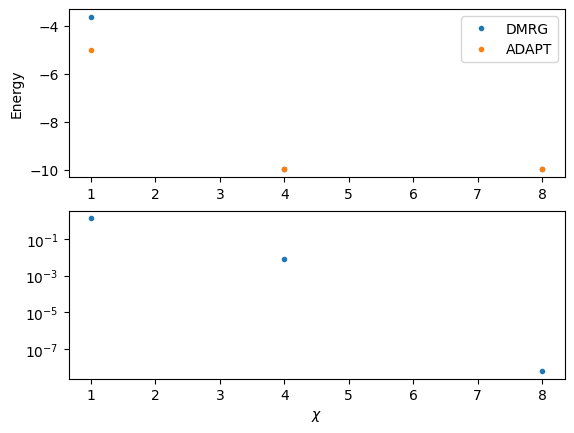

In [12]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(df["chi"], df["dmrg_energy"], '.', label="DMRG")
ax[0].plot(df["chi"], df["adapt_energy"], '.', label="ADAPT")
ax[0].legend()
ax[0].set_ylabel("Energy")
ax[1].plot(df["chi"], df["error"], '.')
ax[1].set_yscale("log")
ax[1].set_xlabel(r"$\chi$")